# DeBERTa

# Libraries

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from transformers import AutoModel, AutoTokenizer, AdamW
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.utils.class_weight import compute_class_weight
from torch.optim.lr_scheduler import StepLR
import json
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt

ImportError: cannot import name 'AdamW' from 'transformers' (/usr/local/lib/python3.11/dist-packages/transformers/__init__.py)

# Ensure GPU access

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

print(f'Using device: {device}')

# Load and preprocess the dataset


In [ ]:
df = pd.read_csv("label_edited.csv",
                 sep='\t',
                 encoding='utf-8',
                 header=0)

df = df[['processed_text', 'mode', 'annotation_label']].dropna()

## Label handling

### Multilabel classification

Here we handle multilabel classification split (Acc5, Acc7, ...), by mapping the labels from eg. for Acc3 `{-1, 0, 1}` -> `{0, 1, 2}` (because the model expects labels in this format)

In [ ]:
# label_mapping = {-1: 0,
#                   0: 1,
#                   1: 2} # Map labels {-1, 0, 1} -> {0, 1, 2}

# df['annotation_label'] = df['annotation_label'].map(label_mapping).astype(int)

### Binary classification

In [ ]:
# df['annotation_label'] = df['annotation_label'].astype(float)

## Subset Splitting


### Our split

Here we make the split by using a function
- Splits into **train**, **validation** and **test** set (80%/10%/10%)

In [ ]:
# train_text, testval_text, train_labels, testval_labels = train_test_split(df['processed_text'], df['annotation_label'],
#                                                                          random_state=42,
#                                                                          test_size=0.2,
#                                                                          stratify=df['annotation_label'])

# # Split the remaining 20% into 10% validation and 10% test sets
# val_text, test_text, val_labels, test_labels = train_test_split(testval_text, testval_labels,
#                                                                 random_state=42,
#                                                                 test_size=0.5,
#                                                                 stratify=testval_labels)

### Dataset's split

Here we use the dataset's preset split, in order to compare we other models

In [ ]:
df['annotation_label'] = df['annotation_label'].astype(float)

In [ ]:
train_text = df[df['mode'] == 'train']['processed_text']
train_labels = df[df['mode'] == 'train']['annotation_label']

val_text = df[df['mode'] == 'valid']['processed_text']
val_labels = df[df['mode'] == 'valid']['annotation_label']

test_text = df[df['mode'] == 'test']['processed_text']
test_labels = df[df['mode'] == 'test']['annotation_label']

#  Load pre-trained DeBERTa model and tokenizer

We basically load the pre-trained DeBERTa model and tokenizer from the `transformers` library.
Since we don't want to update the DeBERTa's weights, we use AutoModel and AutoTokenizer classes with the `from_pretrained` method to load the pre-trained model and tokenizer respectively (not the `forSequenceClassification` version of the model). We will just fine-tune the classifier head of the model.
The classifier head is a single linear layer that takes the output of the last hidden layer of the DeBERTa model and maps it to the number of classes in the dataset.

In [ ]:
deberta = AutoModel.from_pretrained('microsoft/deberta-base')
tokenizer = AutoTokenizer.from_pretrained('microsoft/deberta-base')

In [2]:
from transformers import AutoTokenizer, DebertaForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-base")
model = DebertaForSequenceClassification.from_pretrained("microsoft/deberta-base")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/474 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/559M [00:00<?, ?B/s]

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
model

DebertaForSequenceClassification(
  (deberta): DebertaModel(
    (embeddings): DebertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=0)
      (LayerNorm): DebertaLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): DebertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaLayer(
          (attention): DebertaAttention(
            (self): DisentangledSelfAttention(
              (in_proj): Linear(in_features=768, out_features=2304, bias=False)
              (pos_dropout): Dropout(p=0.1, inplace=False)
              (pos_proj): Linear(in_features=768, out_features=768, bias=False)
              (pos_q_proj): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): DebertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): DebertaLayerNorm()
              (dropout): Dropout(p=0

In [ ]:
deberta

DebertaModel(
  (embeddings): DebertaEmbeddings(
    (word_embeddings): Embedding(50265, 768, padding_idx=0)
    (LayerNorm): DebertaLayerNorm()
    (dropout): StableDropout()
  )
  (encoder): DebertaEncoder(
    (layer): ModuleList(
      (0-11): 12 x DebertaLayer(
        (attention): DebertaAttention(
          (self): DisentangledSelfAttention(
            (in_proj): Linear(in_features=768, out_features=2304, bias=False)
            (pos_dropout): StableDropout()
            (pos_proj): Linear(in_features=768, out_features=768, bias=False)
            (pos_q_proj): Linear(in_features=768, out_features=768, bias=True)
            (dropout): StableDropout()
          )
          (output): DebertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): DebertaLayerNorm()
            (dropout): StableDropout()
          )
        )
        (intermediate): DebertaIntermediate(
          (dense): Linear(in_features=768, out_features=3

## Freeze DeBERTa
In some cases, it might be interesting to keep the weights of the pre-trained encoder frozen and optimizing only the weights of the head layers.

In [ ]:
# for param in deberta.parameters():
#     param.requires_grad = False

In [ ]:
# for param in deberta.encoder.layer[11].parameters():
#     param.requires_grad = True

# for param in deberta.encoder.layer[10].parameters():
#     param.requires_grad = True

# for param in deberta.encoder.layer[9].parameters():
#     param.requires_grad = True

# for param in deberta.encoder.layer[8].parameters():
#     param.requires_grad = True

# for param in deberta.encoder.layer[7].parameters():
#     param.requires_grad = True

# for param in deberta.encoder.layer[6].parameters():
#     param.requires_grad = True

# for param in deberta.encoder.layer[5].parameters():
#     param.requires_grad = True

# for param in deberta.encoder.layer[4].parameters():
#     param.requires_grad = True

# for param in deberta.encoder.layer[3].parameters():
#     param.requires_grad = True

# for param in deberta.encoder.layer[2].parameters():
#     param.requires_grad = True

# for param in deberta.encoder.layer[1].parameters():
#     param.requires_grad = True

# for param in deberta.encoder.layer[0].parameters():
#     param.requires_grad = True

# for param in deberta.rel_embeddings.parameters():
#     param.requires_grad = True

# for param in deberta.embeddings.parameters():
#     param.requires_grad = True

In [ ]:
for name, param in deberta.named_parameters():
        if 'deberta' or 'classifier' or 'pre_classifier' in name:
            print(f'{name}: {param.requires_grad}')

embeddings.word_embeddings.weight: True
embeddings.LayerNorm.weight: True
embeddings.LayerNorm.bias: True
encoder.layer.0.attention.self.q_bias: True
encoder.layer.0.attention.self.v_bias: True
encoder.layer.0.attention.self.in_proj.weight: True
encoder.layer.0.attention.self.pos_proj.weight: True
encoder.layer.0.attention.self.pos_q_proj.weight: True
encoder.layer.0.attention.self.pos_q_proj.bias: True
encoder.layer.0.attention.output.dense.weight: True
encoder.layer.0.attention.output.dense.bias: True
encoder.layer.0.attention.output.LayerNorm.weight: True
encoder.layer.0.attention.output.LayerNorm.bias: True
encoder.layer.0.intermediate.dense.weight: True
encoder.layer.0.intermediate.dense.bias: True
encoder.layer.0.output.dense.weight: True
encoder.layer.0.output.dense.bias: True
encoder.layer.0.output.LayerNorm.weight: True
encoder.layer.0.output.LayerNorm.bias: True
encoder.layer.1.attention.self.q_bias: True
encoder.layer.1.attention.self.v_bias: True
encoder.layer.1.attention.s

## Tokenize and encode sequences


This is the maximum length of the input sequence expected by the model. If the length of the input sequence is greater than this, it will be truncated to this length. If the length of the input sequence is less than this, it will be padded to this length.

- Due to lack of computational power & since BERT can only handle max 512 tokens.

In [ ]:
df['processed_text'].str.len().max()

575

In [ ]:
df['processed_text'].str.len().mean()

61.13460663938154

We chose close to the mean value

In [ ]:
MAX_LEN = 128               # from {128, 256}

Here we tokenize and encode the sequences using the BERT tokenizer. We also truncate the sequences to the maximum length and pad them to the maximum length.

In [ ]:
def tokenize_and_encode(texts):
    return tokenizer.batch_encode_plus(
        texts.tolist(),
        max_length=MAX_LEN,
        padding='max_length',
        truncation=True,
        return_token_type_ids=False
    )

In [ ]:
tokens_train = tokenize_and_encode(train_text)
tokens_val = tokenize_and_encode(val_text)
tokens_test = tokenize_and_encode(test_text)

# Best hyperparameters found
Here we load the best hyperparameters found during our grid search / tuning process using the `Aristotelis Cluster HPC`

In [ ]:
epochs = 5

In [ ]:
learning_rate = 1e-5            # The initial learning rate. The scheduler decreases it later...
weight_decay = 1e-4

In [ ]:
hidden_size = 256               # from {32, 64, 128, 256}
batch_size = 8                  # from {8, 16, 32}
dropout_p = 0.3                 # from {0.1, 0.3}
activation_fn = 'No'          # from {ReLU, TanH, Identity}

## Convert lists to tensors

Here we convert the lists of `input_ids`, `attention_masks`, and `labels` to tensors so that they can be used as input to the model and to the Torch DataLoader.

In [ ]:
def to_tensor(encoded_dict, labels):
    return (
        torch.tensor(encoded_dict['input_ids']),
        torch.tensor(encoded_dict['attention_mask']),
        torch.tensor(labels.tolist())
    )

In [ ]:
train_seq, train_mask, train_y = to_tensor(tokens_train, train_labels)
val_seq, val_mask, val_y = to_tensor(tokens_val, val_labels)
test_seq, test_mask, test_y = to_tensor(tokens_test, test_labels)

## Dataloaders

In [ ]:
def create_data_loader(seq, mask, labels, sampler):
    data = TensorDataset(seq, mask, labels)
    return DataLoader(data, sampler=sampler(data), batch_size=batch_size)

In [ ]:
train_dataloader = create_data_loader(train_seq, train_mask, train_y, RandomSampler)    # We use RandomSampler to to generate random indexes
                                                                                        # Basically, draw samples randomly from the train set
                                                                                        # for robustness and better generalization

val_dataloader = create_data_loader(val_seq, val_mask, val_y, SequentialSampler)        # Use SequentialSampler because we just evaluate
test_dataloader = create_data_loader(test_seq, test_mask, test_y, SequentialSampler)    # Use SequentialSampler because we just evaluate

# Model Architecture

In [ ]:
class DeBERTa_Arch(nn.Module):
    def __init__(self, deberta, dropout_p=0.1, hidden_size=768, activation_fn='No'):
        super(DeBERTa_Arch, self).__init__()
        # RoBERTa model
        self.deberta = deberta
        # Dropout layer
        self.dropout = nn.Dropout(dropout_p)
        # Activation Function
        if activation_fn == 'relu':
            self.actvfunc = nn.ReLU()
        elif activation_fn == 'tanh':
            self.actvfunc = nn.Tanh()
        elif activation_fn == 'No':
            self.actvfunc = nn.Identity()
        else:
            raise ValueError("Invalid activation function")
        # FC Layer
        self.fc = nn.Linear(768, hidden_size)   # DeBERTa outputs 768 by default
        # Output layer
        # MULTILABEL CLASSIFICATION
        # self.outp = nn.Linear(hidden_size, 3)    # Assuming 3 classes for classification
        # self.logsoftmax = nn.LogSoftmax(dim=1)
        # BINARY CLASSIFICATION
        self.outp = nn.Linear(hidden_size, 1)    # Assuming 2 classes for classification
        self.sigmoid = nn.Sigmoid()

    def forward(self, sent_id, mask):
        # ----------------------------------------------------------------
        # Pass inputs through BERT
        # We don't fine tune anything in BERT so we just pass the input
        # and take the pooled output (2nd item in tuple) and then pass it
        # through the fully connected layers
        outputs = self.deberta(sent_id, attention_mask=mask)
        cls_hs = outputs.last_hidden_state[:, 0, :]  # CLS token is at index 0 in the sequence
        # ----------------------------------------------------------------
        # Pass through fully connected layers
        # Hidden layer
        x = self.fc(cls_hs)    # Fully connected layer
        x = self.actvfunc(x)        # Activation function
        # Dropout
        x = self.dropout(x)
        # Output layer
        # MULTILABEL CLASSIFICATION
        # x = self.outp(x)
        # x = self.logsoftmax(x)    # Softmax function for multi-class classification
        # BINARY CLASSIFICATION
        x = self.outp(x)
        x = self.sigmoid(x)
        x = x.squeeze(-1)
        # ----------------------------------------------------------------

        return x

In [ ]:
# Initialize the model and move it to GPU
model = DeBERTa_Arch(deberta, dropout_p, hidden_size, activation_fn)
model = model.to(device)

## Optimizer

In [ ]:
# Define optimizer and class weights
optimizer = AdamW(model.parameters(),
                  lr=learning_rate,
                  weight_decay=weight_decay,
                  no_deprecation_warning=True)

## Scheduler

In [ ]:
# # Learning rate scheduler
# # Decays the learning rate of each parameter group by gamma every step_size epochs.
# scheduler = StepLR(optimizer,
#                    step_size=5,
#                    gamma=0.1) # for      epochs <  5: lr = 5e-4
#                               # for  5 < epochs < 10: lr = 5e-5
#                               # for 10 < epochs < 15: lr = 5e-6
#                               # We didn't try more frequent changes because we account for
#                               # computational efficiency - Small lr -> Slower convergance

## Loss function
We use the Cross Entropy Loss function as the loss function because this is a multi-class classification problem.

In [ ]:
# Compute class weights and define loss function
# We compute the class weights to handle the class imbalance problem in the dataset
# so that we reduce the bias towards the majority class
class_wts = compute_class_weight(class_weight='balanced',
                                 classes=np.unique(train_labels),
                                 y=train_labels)

### Multilabel classification
We test both:
- Negative Log Likelihood Loss function
- Cross Entropy Loss

for multilabel classification

In [ ]:
# weights = torch.tensor(class_wts, dtype=torch.float).to(device)

# # loss_func = nn.CrossEntropyLoss(weight=weights)
# loss_func = nn.NLLLoss(weight=weights)              # from {NLLLoss, CrossEntropyLoss}
#                                                     # NLLLoss needs log-softmax output layer
#                                                     # CrossEntropyLoss needs softmax output layer

### Binary classification

We use Binary Cross Entropy Loss (with Logits Loss since we have a sigmoid output layer) for binary classification:

In [ ]:
weights  = torch.tensor(class_wts[1], dtype=torch.float).to(device)  # Weight for positive class only
loss_func = nn.BCEWithLogitsLoss(pos_weight=weights)

### Train function

In [ ]:
def train(model, train_dataloader):
    # Set model to training mode
    model.train()

    total_loss = 0
    total_preds = []
    total_labels = []

    for step, batch in enumerate(train_dataloader):
        # Move batch to GPU (if it is the device we have)
        batch = [r.to(device) for r in batch]
        sent_id, mask, labels = batch

        # Clear previously calculated gradients
        model.zero_grad()

        # Get model predictions and compute loss
        preds = model(sent_id, mask)
        loss = loss_func(preds, labels)

        total_loss += loss.item()

        # Backward pass and gradient clipping
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update optimizer
        optimizer.step()

        # Collect predictions and labels
        preds = preds.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()

        # Store predictions and labels to calculate accuracy after all batches are processed
        total_preds.append(preds)
        total_labels.append(labels)

    # Concatenate accumulated predictions and labels
    total_preds = np.concatenate(total_preds, axis=0)
    total_labels = np.concatenate(total_labels, axis=0)

    # Convert predictions to binary labels for accuracy calculation
    train_labels = (total_preds >= 0.5).astype(int)
    train_accuracy = np.mean(train_labels == total_labels)

    avg_loss = total_loss / len(train_dataloader)
    return avg_loss, train_accuracy, total_preds

### Evaluation function

In [ ]:
def evaluate(model, val_dataloader):
    # Set model to evaluation mode
    model.eval()

    total_loss = 0
    total_preds = []
    for step, batch in enumerate(val_dataloader):
        # Move batch to GPU
        batch = [r.to(device) for r in batch]
        sent_id, mask, labels = batch

        # Deactivate autograd and compute predictions
        # We deactivate autograd because we don't want to update the model's weights
        with torch.no_grad():
            preds = model(sent_id, mask)
            loss = loss_func(preds, labels)
            total_loss += loss.item()

            # Calculate predictions and move to CPU to detach from computational graph
            preds = preds.detach().cpu().numpy()
            total_preds.append(preds)

    avg_loss = total_loss / len(val_dataloader)
    total_preds = np.concatenate(total_preds, axis=0)
    return avg_loss, total_preds

# Training loop

In [ ]:
train_losses, valid_losses = [], []
best_valid_loss = float('inf')
best_valid_loss_epoch = 0

for epoch in range(epochs):
    print(f'\n Epoch {epoch + 1} / {epochs}')

    # Train the model
    train_loss, _, _ = train(model, train_dataloader)
    train_losses.append(train_loss)

    # Evaluate the model on the validation set
    valid_loss, _ = evaluate(model, val_dataloader)
    valid_losses.append(valid_loss)

    # Step the scheduler
    # scheduler.step()

    print(f'Training Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')

    # Save the model if it has the best validation loss so far
    if valid_loss <= best_valid_loss:   # If we find one with the same, keep the one with the biggest epoch
        best_valid_loss = valid_loss
        best_valid_loss_epoch = epoch + 1
        torch.save(model.state_dict(), 'DeBERTa_best_model_state.bin')


 Epoch 1 / 5
Training Loss: 0.615
Validation Loss: 0.526

 Epoch 2 / 5
Training Loss: 0.536
Validation Loss: 0.529

 Epoch 3 / 5
Training Loss: 0.521
Validation Loss: 0.525

 Epoch 4 / 5
Training Loss: 0.507
Validation Loss: 0.518

 Epoch 5 / 5
Training Loss: 0.502
Validation Loss: 0.509


### Optimal Epochs

In [ ]:
print("Optimal epoch: ", best_valid_loss_epoch)

Optimal epoch:  5


## Learning Curve

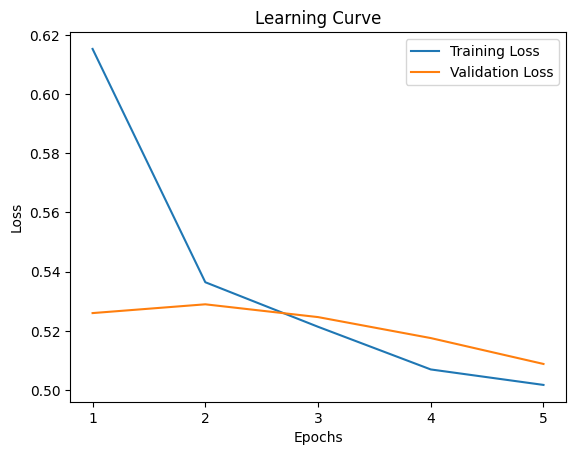

In [ ]:
# Plot the learning curve
plt.plot(range(1, epochs+1), train_losses,
         label='Training Loss')
plt.plot(range(1, epochs+1), valid_losses,
         label='Validation Loss')
plt.xticks(range(1, epochs+1))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

# Load the optimal epoch model

In [ ]:
# Initialize a model and move it to GPU
model_opt = DeBERTa_Arch(deberta, dropout_p, hidden_size, activation_fn)
model_opt = model.to(device)

# Load
model_opt.load_state_dict(torch.load('DeBERTa_best_model_state.bin'))      # Load the saved state dictionary
model_opt.eval()                                                                # Set the model to evaluation mode

<ipython-input-127-c39016ef008c>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_opt.load_state_dict(torch.load('DeBERTa_best_model_state.bin'))      # Load the saved

DeBERTa_Arch(
  (deberta): DebertaModel(
    (embeddings): DebertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=0)
      (LayerNorm): DebertaLayerNorm()
      (dropout): StableDropout()
    )
    (encoder): DebertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaLayer(
          (attention): DebertaAttention(
            (self): DisentangledSelfAttention(
              (in_proj): Linear(in_features=768, out_features=2304, bias=False)
              (pos_dropout): StableDropout()
              (pos_proj): Linear(in_features=768, out_features=768, bias=False)
              (pos_q_proj): Linear(in_features=768, out_features=768, bias=True)
              (dropout): StableDropout()
            )
            (output): DebertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): DebertaLayerNorm()
              (dropout): StableDropout()
            )
          )
          (intermediate): Deber

## Metrics

In [ ]:
# Assuming you have already created test_dataloader
avg_loss, test_preds = evaluate(model_opt, test_dataloader)

# Print the results
print(f'Average Loss: {avg_loss:.4f}')

Average Loss: 0.5883


### Multilabel Classification

In [ ]:
# inverted_mapping = {v: k for k, v in label_mapping.items()}

# predicted_labels = np.argmax(test_preds, axis=1)

# # Mapping using the inverted mapping
# # from {0, 1, 2} back to the original labeling {-1, 0, 1}
# predicted_labels_unmapped = np.array(list(map(lambda x: inverted_mapping[x], predicted_labels)))
# test_y_unmapped = np.array(list(map(lambda x: inverted_mapping[x], test_y.numpy())))

In [ ]:
# # Print the classification report
# print(classification_report(test_y_unmapped, predicted_labels_unmapped, digits=4))

### Binary Classification

In [ ]:
predicted_labels = (test_preds >= 0.5)

In [ ]:
# Print the classification report
print(classification_report(test_y, predicted_labels, digits=4))

              precision    recall  f1-score   support

         0.0     0.8342    0.8496    0.8418       379
         1.0     0.8100    0.7915    0.8007       307

    accuracy                         0.8236       686
   macro avg     0.8221    0.8206    0.8212       686
weighted avg     0.8234    0.8236    0.8234       686



In [ ]:
confusion_matrix = pd.crosstab(test_y, predicted_labels)

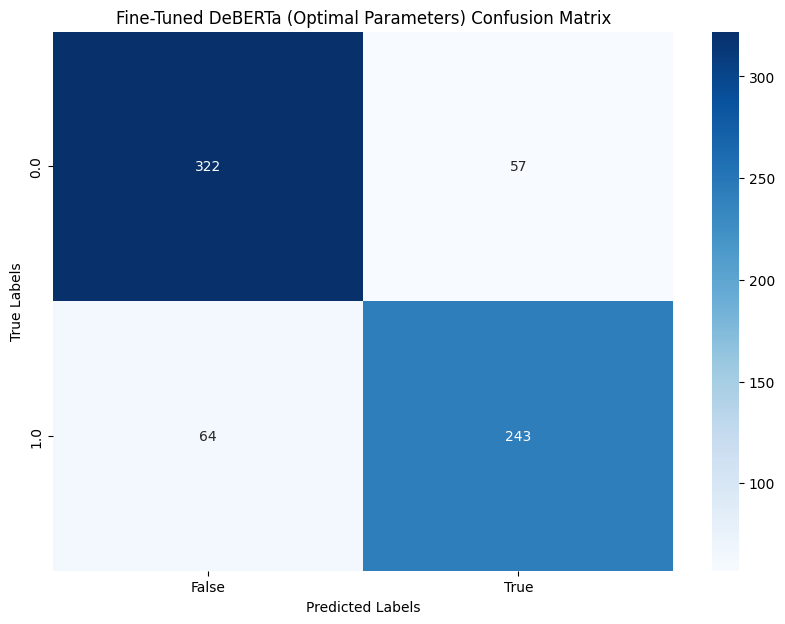

In [ ]:
# Set the size of the figure
plt.figure(figsize=(10, 7))

# Create a heatmap from the confusion matrix
sns.heatmap(confusion_matrix,
            annot=True,
            fmt='d',
            cmap='Blues',
            cbar=True)

# Set titles and labels
plt.title('Fine-Tuned DeBERTa (Optimal Parameters) Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Show the plot
plt.show()